In [106]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 
import torch.nn.functional as F
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import itertools

In [107]:
#transforming the data to be useable and turning them into tensors so it works with pytorch
means = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)

train_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize(means, std)])

test_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize(means, std)])



In [108]:
#defining the parameters so we can do testing and training 
num_epochs = 25
batch_size = 20
learning_rate = 0.001

In [109]:
#importing the dataset CIFAR10 into train and test data


train_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=True,
                                        download=True, transform=train_transform)

test_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=False,
                                       download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
                                          

valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

170499072it [00:06, 25462204.78it/s]                               


Extracting cifar-10-batches-py/cifar-10-python.tar.gz to cifar-10-batches-py
Files already downloaded and verified


In [110]:
#the classes we can have as the answers so out model can train and get the answers (all possible answers)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


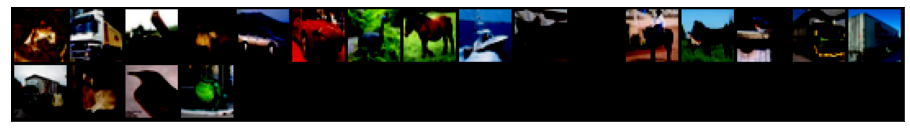

In [111]:
#just trying to visualise how the pictures look so just used this funciton to display the images (will change due to the batch number you use)
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [113]:
#implementing a simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(400, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84,10)

    def forward(self, x):
        #implementing the layers with activation functions ReLU
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return x

In [114]:
modelN = NeuralNetwork()
print(modelN)

NeuralNetwork(
  (l1): Linear(in_features=400, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
)


In [115]:
#creating the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #defining things we will do to the data so here we are adding 2 conv layers along with a pooling to get our size to 5x5 image
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)
        self.batch = nn.BatchNorm2d(64)
        #Dropout = nn.Dropout
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    #forward pass doing the layers from the diagram specified in the report
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5) 
        x = self.fc1(x)
        x = F.relu(x)  
        x = self.fc2(x)
        x = F.relu(x)         
        x = self.fc3(x)                       
        return x

In [116]:
#displaying the model to see if it has the correct layers done to it
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [117]:
#creating a model to train on
model = CNN().to(device)
#creating the loss cross Entropy loss which is the same as softmax
criterion = nn.CrossEntropyLoss()
#using optimizers and trying both Adam and gradient descent to see which model has the best results
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [118]:
def difference(arr):
    return [item-arr[i-1] for i, item in enumerate(arr) if i != 0]

In [119]:
#this is how we keep track of the train_loss and val_loss so we can plot a graph at the end to see if we overfit or not
train_losses = []
valid_losses = []

#iterating for the number of epochs stated above
for epoch in range(num_epochs):
    #refreshing the train and valid_loss so we dont keep adding onto the previous value because then we will get a loss graph increasing rather than decreasing
    train_loss = 0.0
    valid_loss = 0.0
    #this lets the model know we are training
    model.train()
    #iterating the train_loader which has all of our training images
    for i, (data, target) in enumerate(train_loader):
        #choosing the data and target device to run on if we have a gpu available
        data = data.to(device)
        target = target.to(device)
        #clearing the gradient so we dont have any uneccesary data tracking and its all fresh for every epoch
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
 
        # Backward and optimize
        loss.backward()
        optimizer.step()

        #this gives us the train_loss calculation
        train_loss+=loss.item() * data.size(0)

    #this tells the program that we are validating now
    model.eval()
    #now iterating the validation pictures to test on
    for data, target in valid_loader:
        #choosing the data and target device to run on if we have a gpu available
        data = data.to(device)
        target = target.to(device)
        #forward pass
        output = model(data)
        loss = criterion(output, target)

        #we dont use backward pass for testing as we are not learning and only going forward to see if it gets it correct
        
        #calculating the validation loss 
        valid_loss += loss.item() * data.size(0)
    
    #
    #I used this code from the lab9 cactus_classification to be able to draw a graph
    #
    # calculating the loss of the training and validation and adding them to the lists so we can plot a graph afterwards
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    #stopping criteria
    diff = difference(valid_losses[-3:])
    #print(diff)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
    #stopping criteria comment out if you dont want it running
    if len(diff) >= 2:
        #print(diff)
        if((diff[-1] > 0) and (diff[-2] > 0)):
            break
        #debugging my stopping criteria
        print(f'last change in the validation loss is: {diff[-1]}')
      

Epoch: 1 	Training Loss: 1.6043 	Validation Loss: 1.3933
Epoch: 2 	Training Loss: 1.2985 	Validation Loss: 1.2499
Epoch: 3 	Training Loss: 1.1736 	Validation Loss: 1.1785
-0.07144904375076289
Epoch: 4 	Training Loss: 1.0932 	Validation Loss: 1.1440
-0.03446506786346437
Epoch: 5 	Training Loss: 1.0314 	Validation Loss: 1.1355
-0.008499323010444648
Epoch: 6 	Training Loss: 0.9814 	Validation Loss: 1.1304
-0.005093415021896419
Epoch: 7 	Training Loss: 0.9397 	Validation Loss: 1.1430
0.012650619745254499
Epoch: 8 	Training Loss: 0.9057 	Validation Loss: 1.1349
-0.008118948400020587
Epoch: 9 	Training Loss: 0.8755 	Validation Loss: 1.1591
0.024178626239299783
Epoch: 10 	Training Loss: 0.8498 	Validation Loss: 1.1693


In [120]:
#saving to model as CifarModel
torch.save(model.state_dict(), 'CifarModel')

doing analysis of the CNN modelling with loss graphs, accuracy and confusion matrix below

In [121]:
#another validation but for this block I am calculating the accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    #iterate the test dataset with all the test images
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        #forward pass with no loss because we are just predicting here and getting accuracy
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    #doing the calculations to get average accuracy to see how well our model performed
    total_acc = 100.0 * correct / total 
    #displays the accuracy
    print(f'average accuracy {total_acc}%')

    

average accuracy 61.6%


In [122]:
# I found this code online to help me get some values so I could draw a confusiion matrix link : https://deeplizard.com/learn/video/0LhiS6yu2qQ
# the code creates an empty tensor all_preds and then takes all prediction when it runs the model on the images in the test_loader 
#then it concatanates all of the predictions into the all_preds tensor using torch.cat and then we have the predictions we will use in the confusion matrix
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    predictions = model(images)
    all_preds = torch.cat((all_preds, predictions))

  return all_preds

In [123]:
#running the get_all_preds function to draw a confusion matrix
test_prediction = get_all_preds(model, valid_loader)
#giving the confusion matrix the things we are modeling with 
cm = confusion_matrix(test_dataset.targets, test_prediction.argmax(dim=1))


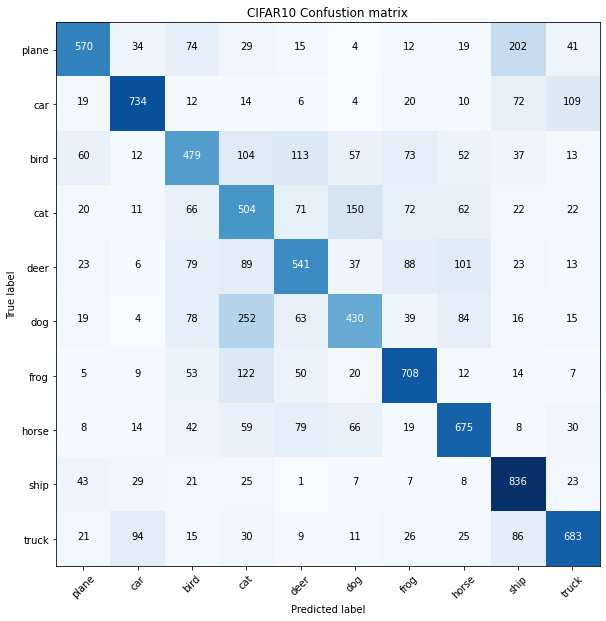

In [124]:
#drawing the matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CIFAR10 Confustion matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
t = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),horizontalalignment="center",
             color="white" if cm[i, j] > t else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

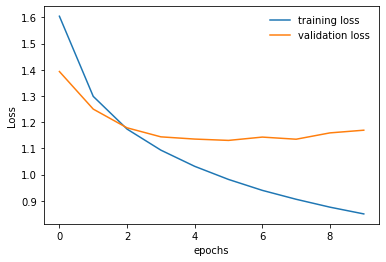

In [125]:
plt.plot(train_losses, label = 'training loss')
plt.plot(valid_losses, label = 'validation loss')

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(frameon = False)